In [ ]:
# ASN Pairings Mean MOS, Mean Qualfun, and Percentage "Bad" Calls

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import geoip2.database
import ipaddress
import os
import dask.dataframe as dd

In [5]:
# functions to get AS info
def getASobject(x):
    ip = ipaddress.ip_address(x)
    try: return readerASN.asn(str(ip))
    except: return "The address {} is not in the database.".format(ip)
def getIP(x):
    if type(x) == str: return x
    return x.ip_address
def getASN(x):
    if type(x) == str: return x
    return x.autonomous_system_number
def getASorg(x):
    if type(x) == str: return x
    return x.autonomous_system_organization
def getInt(x):
    return int(x)

In [20]:
def getcount(row):
    a=int(row['a_saddr'])
    b=int(row['b_saddr'])
    
    df_asaddr=df['a_saddr']
    df_new=df[df['a_saddr']==a][df['b_saddr']==b]

    return len(df_new)

def getbadcount(row):
    a=int(row['a_saddr'])
    b=int(row['b_saddr'])
    
    df_asaddr=df_filtered['a_saddr']
    df_new=df_filtered[df_filtered['a_saddr']==a][df_filtered['b_saddr']==b]

    return len(df_new)

def getbadratio(row):
    total_count=float(row['count'])
    bad_count=float(row['bad_count'])

    return bad_count/total_count

def getQualfunmean(row):
    a=int(row['a_saddr'])
    b=int(row['b_saddr'])
    
    df_asaddr=df['a_saddr']
    df_new=df[df['a_saddr']==a][df['b_saddr']==b]

    return df_new['Qualfun'].mean()

def getmosmean(row):
    a=int(row['a_saddr'])
    b=int(row['b_saddr'])
    
    df_asaddr=df['a_saddr']
    df_new=df[df['a_saddr']==a][df['b_saddr']==b]

    return df_new['b_mos_adapt_mult10'].mean()

In [7]:
def evaluaterow(a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, b1, b2, b3, b4, b5, b6, b7, b8, b9, b10, a_delay_sum, b_delay_sum, connect_duration):

    a_top_sum = get_top_sum(a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a_delay_sum)
    b_top_sum = get_top_sum(b1, b2, b3, b4, b5, b6, b7, b8, b9, b10, b_delay_sum)
    
    a_bot_sum = get_top_sum(a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, connect_duration)
    b_bot_sum = get_top_sum(b1, b2, b3, b4, b5, b6, b7, b8, b9, b10, connect_duration)
    
    sum_a = a_top_sum/a_bot_sum
    sum_b = b_top_sum/b_bot_sum
    
    total_sum = (sum_a+sum_b)/2 
    return total_sum
    
def get_top_sum(a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, delay_sum):
    top_sum = 0
    n = 1
    w1 = 1
    w2 = 1
    w3 = 1
    w4 = 1
    w5 = 1
    w6 = 1
    w7 = 1
    w8 = 1
    w9 = 1
    w10 = 1
    
    top_sum += 20*n*(a1)*w1
    n += 1
    top_sum += 20*n*(a2)*w2
    n += 1
    top_sum += 20*n*(a3)*w3
    n += 1
    top_sum += 20*n*(a4)*w4
    n +=1
    top_sum += 20*n*(a5)*w5
    n += 1
    top_sum += 20*n*(a6)*w6
    n += 1
    top_sum += 20*n*(a7)*w7
    n +=1
    top_sum += 20*n*(a8)*w8
    n += 1
    top_sum += 20*n*(a9)*w9
    n += 1
    top_sum += 20*n*(a10)*w10
    
    return(top_sum + delay_sum)

def get_bot_sum(a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, connect_duration):
    
    bot_sum = 0
    n = 1
    w1 = 1
    w2 = 1
    w3 = 1
    w4 = 1
    w5 = 1
    w6 = 1
    w7 = 1
    w8 = 1
    w9 = 1
    w10 = 1
    
    bot_sum += 20*n*(a1)*(1-w1)
    n += 1
    bot_sum += 20*n*(a2)*(1-w2)
    n += 1
    bot_sum += 20*n*(a3)*(1-w3)
    n += 1
    bot_sum += 20*n*(a4)*(1-w4)
    n +=1
    bot_sum += 20*n*(a5)*(1-w5)
    n += 1
    bot_sum += 20*n*(a6)*(1-w6)
    n += 1
    bot_sum += 20*n*(a7)*(1-w7)
    n +=1
    bot_sum += 20*n*(a8)*(1-w8)
    n += 1
    bot_sum += 20*n*(a9)*(1-w9)
    n += 1
    bot_sum += 20*n*(a10)*(1-w10)
    
    return(bot_sum + connect_duration)

In [8]:
#DATA_ROOT = 'data/workshop-content18/5-cloudpbx/data/cloudpbx_sample_data_10k/'
CSV_FILE_PATH = os.path.join('pims_cloudpbx_subset_201806051550_1million.csv')
#CSV_FILE_PATH = os.path.join('locn-filtered.csv')
GEOLITE_ASN_PATH = os.path.join('GeoLite2-ASN.mmdb')
GEOLITE_CITY_PATH = os.path.join('GeoLite2-City.mmdb')

# read dataframe
df = pd.read_csv(CSV_FILE_PATH,delim_whitespace=True,low_memory=False)

DESCRIBED_COLUMNS = [#"sipcallerip", "sipcalledip", 
    "a_saddr", "b_saddr"]
                     #"ipaddr_caller","ipaddr_called",
                     #"ipaddr_lat_sip_caller","ipaddr_lat_ip_called","ipaddr_lons_ip_caller","ipaddr_lons_ip_called",
                     #"sipcallerasn","sipcallerasorg","sipcalledasn","sipcalledasorg",
                     #"a_saddr_asn","a_saddr_asorg","b_saddr_asn","b_saddr_asorg"]

df_geo = df[DESCRIBED_COLUMNS]
df_geo = df_geo.drop_duplicates()

# initiate geoip client
readerASN = geoip2.database.Reader(GEOLITE_ASN_PATH)
readerCITY = geoip2.database.Reader(GEOLITE_CITY_PATH)

In [9]:
# making a vector of AS objects for sipcalled
V = df_geo['a_saddr'].apply(getASobject)
# adding columns to the data frame
df_geo['a_saddr_asn'] = V.apply(getASN)
df_geo['a_saddr_asorg'] = V.apply(getASorg)
df_geo['a_saddr_asip'] = V.apply(getIP)

In [10]:
DATA_PATH = ('unique_rtp_pairings.csv')
DESCRIBED_COLUMNS = ["a_saddr","b_saddr","a_saddr_asn","a_saddr_asorg","a_saddr_as_ip","a_saddr_lat","a_saddr_long","b_saddr_asn","b_saddr_asorg","b_saddr_as_ip","b_saddr_lat","b_saddr_long"]

# read dataframe. calldate and callend are the only date columns
df_pairings = pd.read_csv(DATA_PATH)
df_pairings = df_pairings[DESCRIBED_COLUMNS]

In [11]:
df['Qualfun'] = df.apply(lambda df: pd.Series(evaluaterow(df['a_sl1'],df['a_sl2'],df['a_sl3'],df['a_sl4'],df['a_sl5'],df['a_sl6'],df['a_sl7'],df['a_sl8'],df['a_sl9'],df['a_sl10'],df['b_sl1'],df['b_sl2'],df['b_sl3'],df['b_sl4'],df['b_sl5'],df['b_sl6'],df['b_sl7'],df['b_sl8'],df['b_sl9'],df['b_sl10'],df['a_delay_sum'],df['b_delay_sum'],df['duration'])), axis=1)

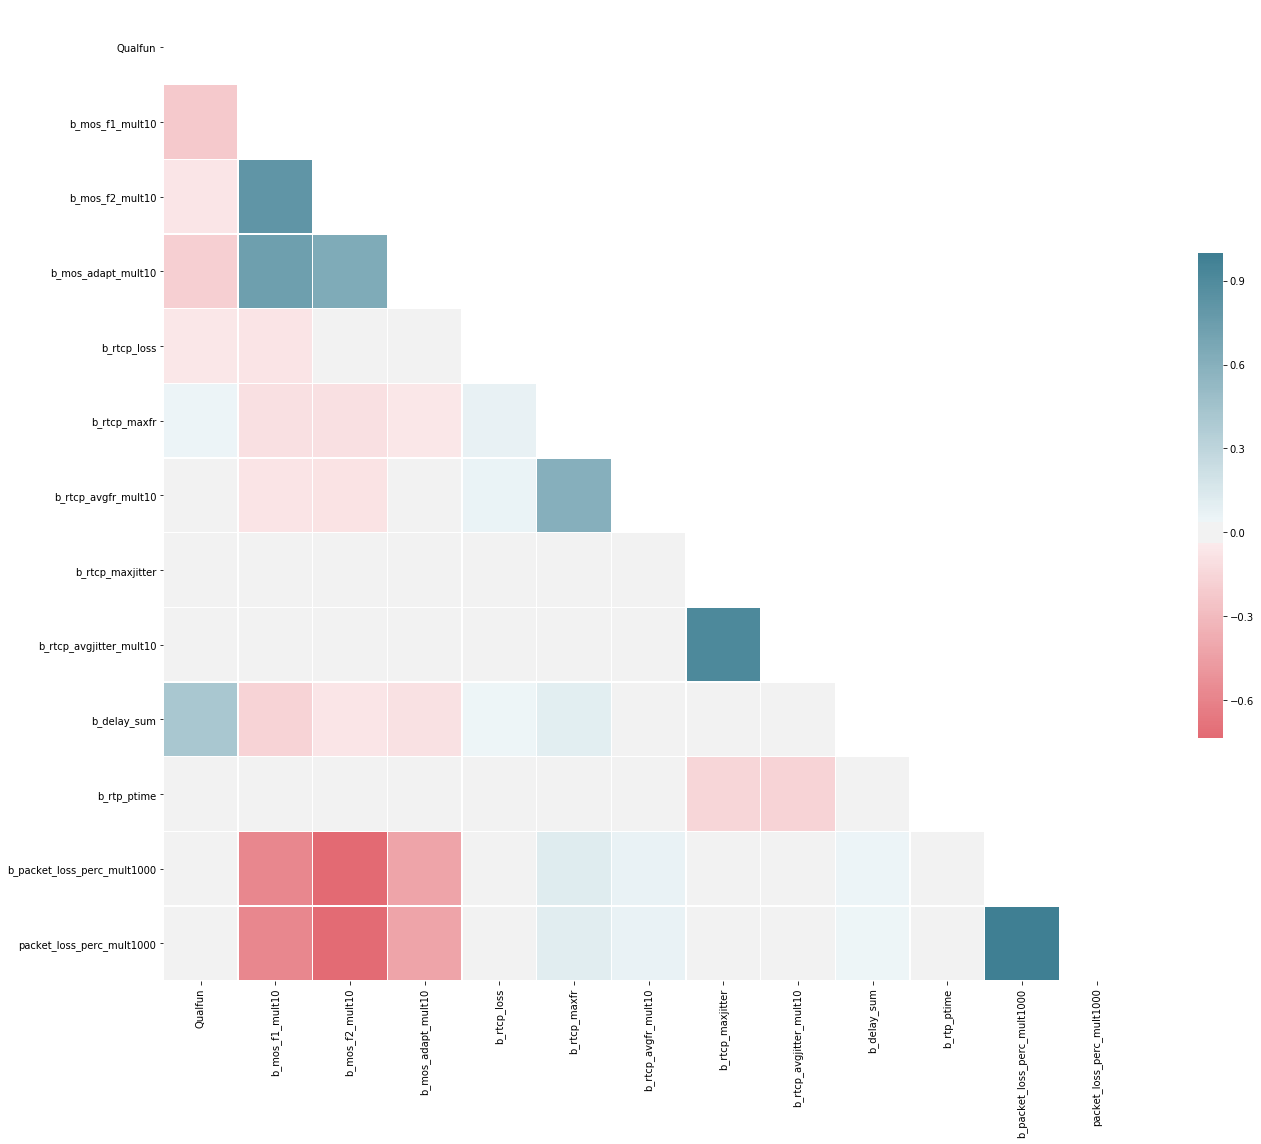

In [12]:
df_new=df[df['b_mos_adapt_mult10']>0]
corr=df_new[['Qualfun','b_mos_f1_mult10','b_mos_f2_mult10','b_mos_adapt_mult10','b_rtcp_loss','b_rtcp_maxfr','b_rtcp_avgfr_mult10','b_rtcp_maxjitter','b_rtcp_avgjitter_mult10','b_delay_sum','b_rtp_ptime','b_packet_loss_perc_mult1000','packet_loss_perc_mult1000']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.rcParams['axes.labelsize'] = 10
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});
plt.tight_layout()
plt.savefig('./img/jitter_vs_mos_vs_Qualfun_mosgt0_1million.png', dpi=600)

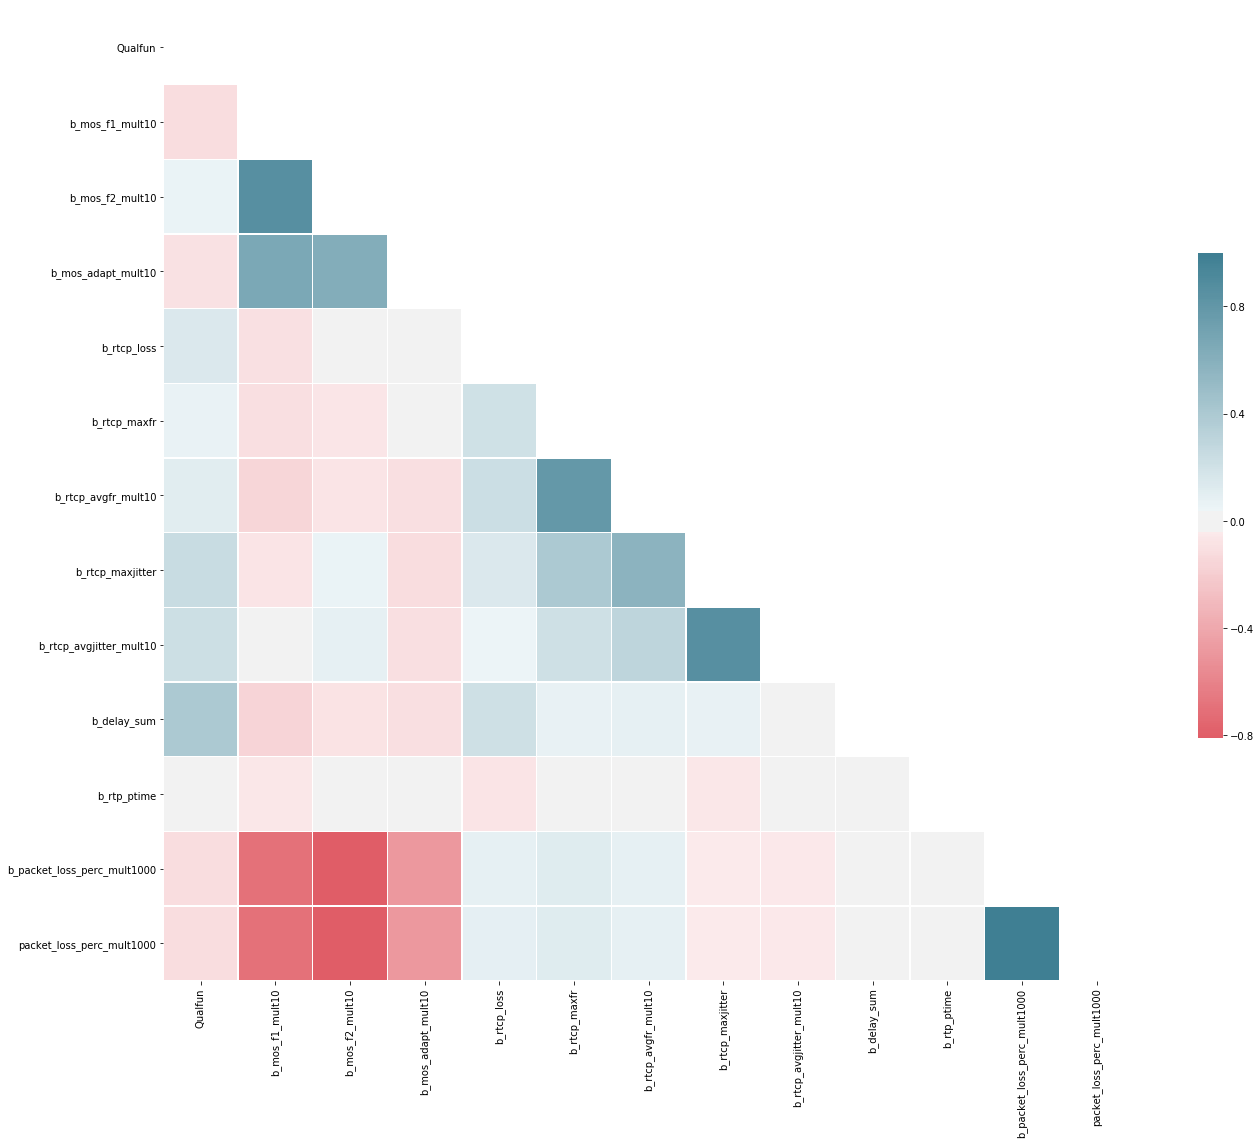

In [15]:
df_new=df_new[df_new['b_mos_adapt_mult10']<40]
corr=df_new[['Qualfun','b_mos_f1_mult10','b_mos_f2_mult10','b_mos_adapt_mult10','b_rtcp_loss','b_rtcp_maxfr','b_rtcp_avgfr_mult10','b_rtcp_maxjitter','b_rtcp_avgjitter_mult10','b_delay_sum','b_rtp_ptime','b_packet_loss_perc_mult1000','packet_loss_perc_mult1000']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.rcParams['axes.labelsize'] = 10
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});
plt.tight_layout()
plt.savefig('./img/jitter_vs_mos_vs_Qualfun_mosgt0lt40_1million.png', dpi=600)

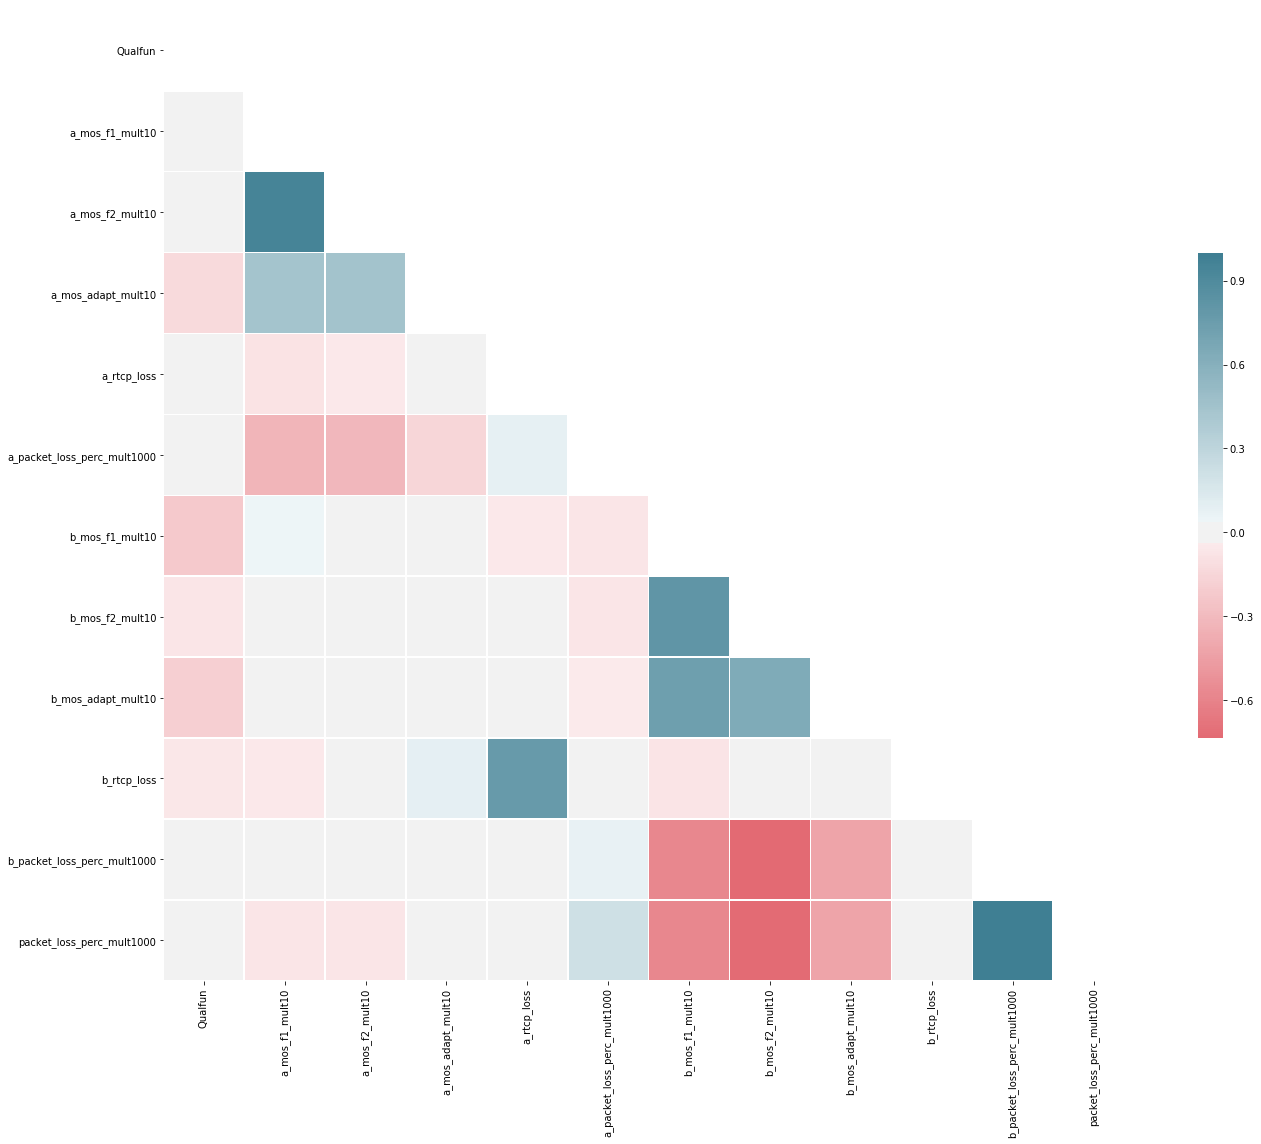

In [24]:
df_new=df[df['b_mos_adapt_mult10']>0]
corr=df_new[['Qualfun','a_mos_f1_mult10','a_mos_f2_mult10','a_mos_adapt_mult10','a_rtcp_loss','a_packet_loss_perc_mult1000','b_mos_f1_mult10','b_mos_f2_mult10','b_mos_adapt_mult10','b_rtcp_loss','b_packet_loss_perc_mult1000','packet_loss_perc_mult1000']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.rcParams['axes.labelsize'] = 10
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});
plt.tight_layout()
plt.savefig('./img/a_vs_b_jitter_vs_mos_vs_Qualfun_mosgt0_1million.png', dpi=600)

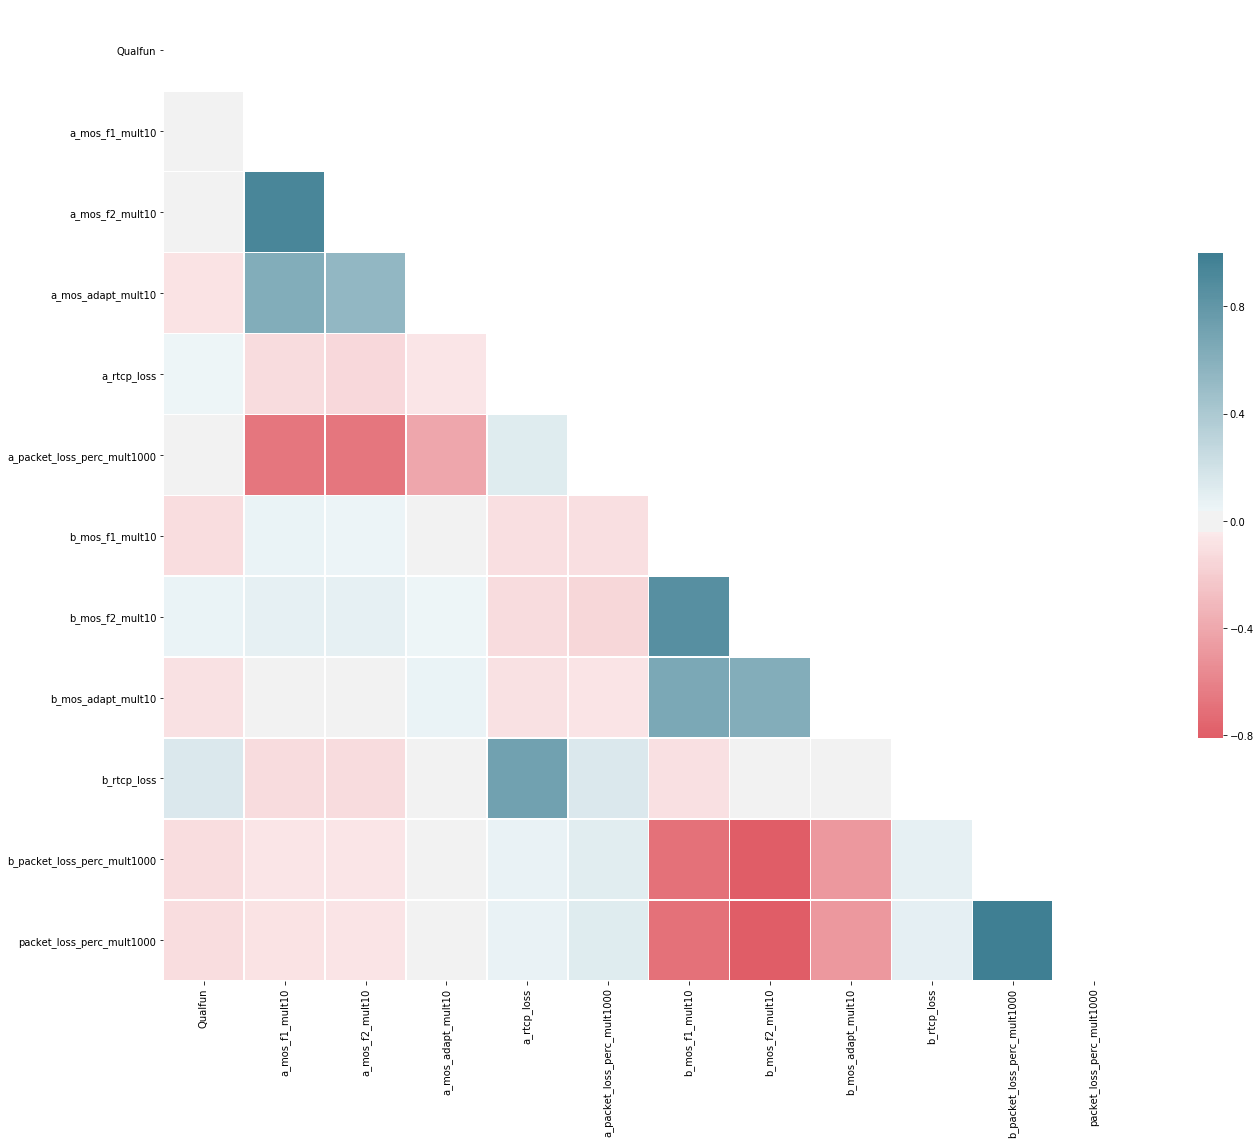

In [25]:
df_new=df_new[df_new['b_mos_adapt_mult10']<40]
corr=df_new[['Qualfun','a_mos_f1_mult10','a_mos_f2_mult10','a_mos_adapt_mult10','a_rtcp_loss','a_packet_loss_perc_mult1000','b_mos_f1_mult10','b_mos_f2_mult10','b_mos_adapt_mult10','b_rtcp_loss','b_packet_loss_perc_mult1000','packet_loss_perc_mult1000']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.rcParams['axes.labelsize'] = 10
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});
plt.tight_layout()
plt.savefig('./img/a_vs_b_jitter_vs_mos_vs_Qualfun_mosgt0lt40_1million.png', dpi=600)

In [26]:
## Calculate total count, bad count, bad ratio, mean Qualfun and mean b_mos_adapt_mult10, for saddr pairings.

In [17]:
df_pairings['count']=df_pairings.apply(getcount,axis=1)

/home/mohamed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [65]:
df_filtered=df[df['b_mos_adapt_mult10']>0]
df_filtered=df_filtered[df_filtered['b_mos_adapt_mult10']<40]

df_pairings['bad_count_lt40']=df_pairings.apply(getbadcount,axis=1)

/home/mohamed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


In [21]:
df_pairings['bad_ratio']=df_pairings.apply(getbadratio,axis=1)

In [22]:
df_pairings['mean_Qualfun']=df_pairings.apply(getQualfunmean,axis=1)
df_pairings['mean_b_mos_adapt_mult10']=df_pairings.apply(getmosmean,axis=1)

/home/mohamed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/mohamed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [67]:
df_pairings.head()

,a_saddr,b_saddr,a_saddr_asn,a_saddr_asorg,a_saddr_as_ip,a_saddr_lat,a_saddr_long,b_saddr_asn,b_saddr_asorg,b_saddr_as_ip,b_saddr_lat,b_saddr_long,count,bad_count,bad_ratio,mean_Qualfun,mean_b_mos_adapt_mult10,bad_count_lt40
0,3227975250,41732323,395152,CloudPBX,192.102.254.82,43.6319,-79.3716,5607,Sky UK Limited,2.124.200.227,53.2738,-2.6087,2,0,0.0,1.610616,45.0,0
1,3227975251,41733976,395152,CloudPBX,192.102.254.83,43.6319,-79.3716,5607,Sky UK Limited,2.124.207.88,53.2738,-2.6087,2,0,0.0,10.444028,45.0,0
2,1654599250,69076145,395766,CloudPBX,98.159.46.82,40.7432,-75.2242,3356,"Level 3 Parent, LLC",4.30.4.177,32.8072,-117.1649,1,0,0.0,0.000000,45.0,0
3,3227975251,70715842,395152,CloudPBX,192.102.254.83,43.6319,-79.3716,3356,"Level 3 Parent, LLC",4.55.9.194,37.751,-97.822,26,0,0.0,0.054872,45.0,0
4,3227975250,70715842,395152,CloudPBX,192.102.254.82,43.6319,-79.3716,3356,"Level 3 Parent, LLC",4.55.9.194,37.751,-97.822,20,0,0.0,0.028395,45.0,0


In [31]:
parameters=['bad_ratio','mean_Qualfun','mean_b_mos_adapt_mult10']
len(df_pairings)
#pchoice=4  # choose the parameter in the list "parameter" to create the graph for.
type(df_pairings)

pandas.core.frame.DataFrame

In [95]:
df_asnpairings=df_pairings.groupby(['a_saddr_asn','b_saddr_asn'])[['count','bad_count_lt40']].sum()

In [101]:
aasn_array = []
basn_array = []
parameter_array= []

for row in df_asnpairings.iterrows():
    if float(row[1]['bad_count_lt40'])>10:
        aasn_array.append(int(row[0][0]))
        basn_array.append(int(row[0][1]))
        parameter_array.append(float(row[1]['bad_count_lt40'])/float(row[1]['count']))
    

#asnlist=sorted(list(set(df['a_saddr_asn'].unique()).union(set(df['b_saddr_asn'].unique()))))

no_entries=len(aasn_array)
asnlist=sorted(list(set(aasn_array).union(set(basn_array))))

aasnlist=sorted(list(set(aasn_array)))
basnlist=sorted(list(set(basn_array)))
no_aasn=len(aasnlist)
no_basn=len(basnlist)


#no_asn=len(asnlist)
#print(no_aasn)
#print(no_basn)

3
17


In [102]:
asn_par=np.zeros([no_aasn,no_basn])
for i in range(0,no_entries):
    row=aasnlist.index(aasn_array[i])
    column=basnlist.index(basn_array[i])
    asn_par[row,column]=parameter_array[i]

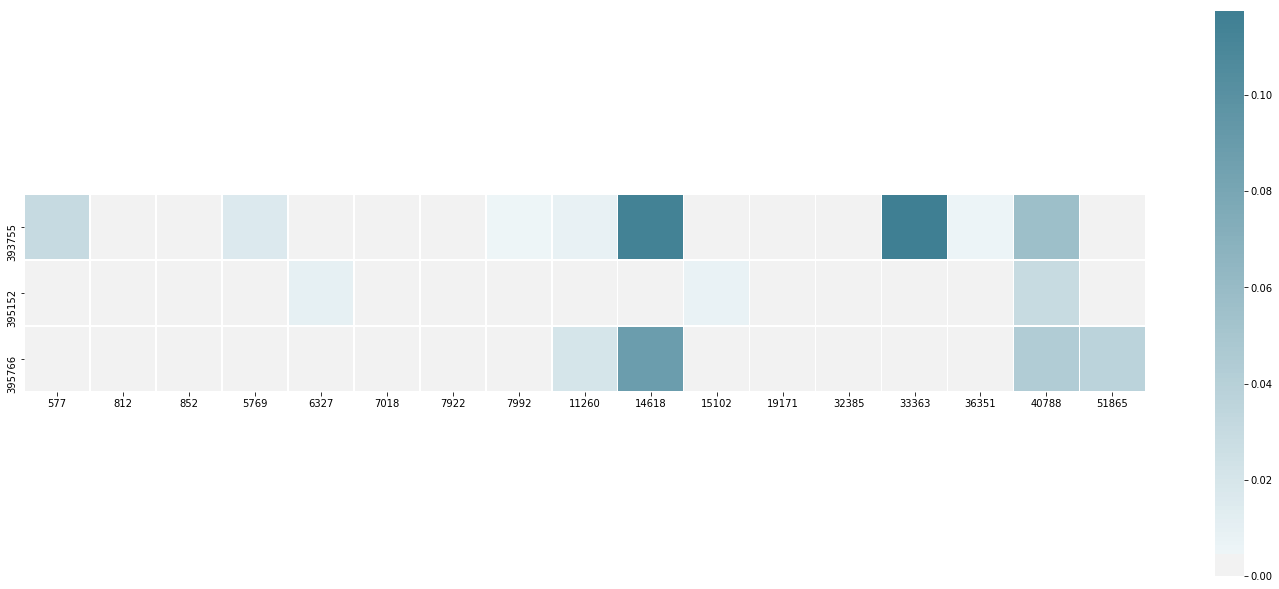

In [112]:
plt.rcParams['axes.labelsize'] = 10
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 16))

# We want to show all ticks...
#ax.set_xticks(np.arange(len(farmers)))
#ax.set_yticks(np.arange(len(vegetables)))
# ... and label them with the respective list entries
#ax.set_xticklabels(basnlist)
#ax.set_yticklabels(aasnlist)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(asn_par, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},yticklabels=aasnlist,xticklabels=basnlist);
plt.tight_layout()
plt.savefig('./img/aasn_vs_baasn_badcallsratio_1million.png', dpi=600)

In [127]:
aasorglist=dict()
aasnlist

for asn in iter(aasnlist):
    aasorglist[asn]=df_pairings[df_pairings['a_saddr_asn']==asn]['a_saddr_asorg'][0:1].values[0]

In [125]:
df_pairings[df_pairings['a_saddr_asn']==393755]['a_saddr_asorg'][0:1].values[0]

'CloudPBX'